In [2]:
import pandas as pd

train_data = pd.read_csv("./data/train.csv")
test_data = pd.read_csv("./data/test.csv")

print(train_data.info()) # 6,995,055개의 데이터
print(test_data.info()) # 1,747,688개의 데이터

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6995056 entries, 0 to 6995055
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   ID      object
 1   URL     object
 2   label   int64 
dtypes: int64(1), object(2)
memory usage: 160.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1747689 entries, 0 to 1747688
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   ID      object
 1   URL     object
dtypes: object(2)
memory usage: 26.7+ MB
None


In [3]:
train_data.head()

,ID,URL,label
0,TRAIN_0000000,poznan[.]wuoz[.]gov[.]pl,0
1,TRAIN_0000001,vill[.]okawa[.]kochi[.]jp,0
2,TRAIN_0000002,nationalfinance[.]co[.]om,0
3,TRAIN_0000003,town[.]ozora[.]hokkaido[.]jp,0
4,TRAIN_0000004,open24[.]ie-news[.]irish/online/Login,1


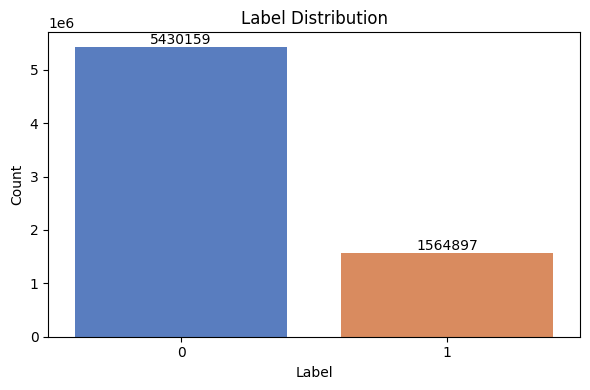

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))  

ax = sns.countplot(
    x='label',
    hue='label',
    data=train_data,
    palette='muted',
    legend=False,  
)

plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')

for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2,   # 막대 중앙 x 위치
        p.get_height() + 0.2,            # 막대 위쪽 y 위치
        f'{int(p.get_height())}',        # 개수 표시
        ha='center', va='bottom'
    )

plt.tight_layout()
plt.show()

In [5]:
train_data['URL'] = train_data['URL'].str.replace('[.]', '.')
test_data['URL'] = test_data['URL'].str.replace('[.]', '.')

In [6]:
import re
import string
import pandas as pd
import math
from collections import Counter

# -----------------------------------
# URL normalize (핵심!)
# -----------------------------------

def normalize_url(url):
    if not re.match(r'^https?://', url):
        return 'http://' + url
    return url

# -----------------------------------
# Helper functions
# -----------------------------------

def count_digits(url):
    return sum(char.isdigit() for char in url)

def count_special_chars(url):
    return sum(char in string.punctuation for char in url)

def extract_domain(url):
    match = re.search(r'://([^/]+)', url)
    return match.group(1) if match else None

def has_digit(s):
    return any(c.isdigit() for c in str(s))

def count_unique_chars(url):
    return len(set(url))

def extract_tld(url):
    match = re.search(r'\.([a-zA-Z]{2,10})(?:/|$)', url)
    return match.group(1).lower() if match else None

def path_part(url):
    match = re.search(r'[^/]+/(.*)', url)
    return match.group(1) if match else ""

def query_part(url):
    match = re.search(r'\?(.*)', url)
    return match.group(1) if match else ""

def calculate_entropy(url):
    counter = Counter(url)
    length = len(url)
    entropy = 0
    for count in counter.values():
        p = count / length
        entropy -= p * math.log2(p)
    return entropy

def check_randomness(url):
    entropy = calculate_entropy(url)
    
    # 연속된 동일 문자 최대 길이
    max_consecutive = current = 1
    for i in range(1, len(url)):
        if url[i].isalnum() and url[i-1].isalnum() and url[i].lower() == url[i-1].lower():
            current += 1
            max_consecutive = max(max_consecutive, current)
        else:
            current = 1
    
    # 숫자 ↔ 문자 전환 횟수
    transitions = 0
    for i in range(1, len(url)):
        if (url[i-1].isdigit() and url[i].isalpha()) or (url[i-1].isalpha() and url[i].isdigit()):
            transitions += 1
    
    # 무작위성 점수 (0~1 정규화)
    entropy_score     = min(entropy / 5.0, 1.0)
    consecutive_score = min(max_consecutive / 10.0, 1.0)
    transition_score  = min(transitions / 10.0, 1.0)
    
    randomness_score = (entropy_score * 0.5 +
                        (1 - consecutive_score) * 0.3 +
                        transition_score * 0.2)
    
    return randomness_score


# -----------------------------------
# Feature Engineering
# -----------------------------------

def add_url_features(df):
    df['URL_norm'] = df['URL'].apply(normalize_url)

    # 길이 기반
    df['length'] = df['URL'].str.len()
    df['subdomain_count'] = df['URL'].str.split('.').str.len()
    df['num_digits'] = df['URL'].apply(count_digits)
    df['num_special_chars'] = df['URL'].apply(count_special_chars)
    df['unique_chars'] = df['URL'].apply(count_unique_chars)

    # domain
    df['domain'] = df['URL_norm'].apply(extract_domain)
    df['domain_length'] = df['domain'].astype(str).str.len()
    df['domain_has_digit'] = df['domain'].apply(has_digit)
    df['num_hyphens'] = df['URL'].str.count('-')
    df['num_underscores'] = df['URL'].str.count('_')

    # IP URL
    df['is_ip_url'] = df['URL_norm'].str.contains(r'^\d{1,3}(\.\d{1,3}){3}')

    # http/https
    df['is_http'] = df['URL_norm'].str.startswith('http://')
    df['is_https'] = df['URL_norm'].str.startswith('https://')

    # :port
    df['has_port'] = df['URL_norm'].str.contains(r':\d{2,5}')

    # @
    df['has_at'] = df['URL_norm'].str.contains('@')

    # path & query
    df['path'] = df['URL_norm'].apply(path_part)
    df['path_length'] = df['path'].str.len()
    df['query'] = df['URL_norm'].apply(query_part)
    df['query_length'] = df['query'].str.len()
    df['num_params'] = df['query'].str.count('=')

    # tld
    df['tld'] = df['URL_norm'].apply(extract_tld)

    # 피싱 키워드
    phishing_keywords = ['login', 'secure', 'update', 'verify', 'account', 'bank',
                         'paypal', 'free', 'bonus', 'admin', 'redirect', 'auth',
                         'signin', 'server', 'click', 'immediate', 'confirm']
    df['has_phish_keyword'] = df['URL'].apply(
        lambda x: any(k in x.lower() for k in phishing_keywords)
    )

    # 무작위성 점수
    df['randomness'] = df['URL'].apply(check_randomness)

    return df


# -----------------------------------
# 실행
# -----------------------------------

train_data = add_url_features(train_data)
train_data.head()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_28624\2791093017.py:109: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['is_ip_url'] = df['URL_norm'].str.contains(r'^\d{1,3}(\.\d{1,3}){3}')


,ID,URL,label,URL_norm,length,subdomain_count,num_digits,num_special_chars,unique_chars,domain,...,has_port,has_at,path,path_length,query,query_length,num_params,tld,has_phish_keyword,randomness
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,http://poznan.wuoz.gov.pl,18,4,0,3,11,poznan.wuoz.gov.pl,...,False,False,/poznan.wuoz.gov.pl,19,,0,0,pl,False,0.600827
1,TRAIN_0000001,vill.okawa.kochi.jp,0,http://vill.okawa.kochi.jp,19,4,0,3,12,vill.okawa.kochi.jp,...,False,False,/vill.okawa.kochi.jp,20,,0,0,jp,False,0.587135
2,TRAIN_0000002,nationalfinance.co.om,0,http://nationalfinance.co.om,21,3,0,2,11,nationalfinance.co.om,...,False,False,/nationalfinance.co.om,22,,0,0,om,False,0.597280
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,http://town.ozora.hokkaido.jp,22,4,0,3,14,town.ozora.hokkaido.jp,...,False,False,/town.ozora.hokkaido.jp,23,,0,0,jp,False,0.593377
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,http://open24.ie-news.irish/online/Login,33,3,2,5,17,open24.ie-news.irish,...,False,False,/open24.ie-news.irish/online/Login,34,,0,0,irish,True,0.667245


In [ ]:
import re
import string
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
import math

tqdm.pandas()
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Optuna 로그 줄이기

# =====================================================
# 1) Feature Engineering (동일)
# =====================================================
def add_url_features(df):
    df['URL_norm'] = df['URL'].apply(normalize_url)
    df['length'] = df['URL'].str.len()
    df['subdomain_count'] = df['URL'].str.split('.').str.len()
    df['num_digits'] = df['URL'].apply(count_digits)
    df['num_special_chars'] = df['URL'].apply(count_special_chars)
    df['unique_chars'] = df['URL'].apply(count_unique_chars)
    df['domain'] = df['URL_norm'].apply(extract_domain)
    df['domain_length'] = df['domain'].astype(str).str.len()
    df['domain_has_digit'] = df['domain'].apply(has_digit)
    df['num_hyphens'] = df['URL'].str.count('-')
    df['num_underscores'] = df['URL'].str.count('_')
    df['is_ip_url'] = df['URL_norm'].str.contains(r'^\d{1,3}(?:\.\d{1,3}){3}(?::\d+)?(?:/|$)')
    df['is_http'] = df['URL_norm'].str.startswith('http://')
    df['is_https'] = df['URL_norm'].str.startswith('https://')
    df['has_port'] = df['URL_norm'].str.contains(r':\d{2,5}')
    df['has_at'] = df['URL_norm'].str.contains('@')
    df['path'] = df['URL_norm'].apply(path_part)
    df['path_length'] = df['path'].str.len()
    df['query'] = df['URL_norm'].apply(query_part)
    df['query_length'] = df['query'].str.len()
    df['num_params'] = df['query'].str.count('=')
    df['tld'] = df['URL_norm'].apply(extract_tld)
    df['randomness'] = df['URL'].apply(check_randomness)
    
    phishing_keywords = ['login', 'secure', 'update', 'verify', 'account', 'bank',
                         'paypal', 'free', 'bonus', 'admin', 'redirect', 'auth',
                         'signin', 'server', 'click', 'immediate', 'confirm']
    df['has_phish_keyword'] = df['URL'].apply(
        lambda x: any(k in x.lower() for k in phishing_keywords)
    )
    return df

# =====================================================
# 2) 데이터 준비
# =====================================================
df = add_url_features(train_data.copy())

le = LabelEncoder()
df['tld_encoded'] = le.fit_transform(df['tld'].astype(str).fillna('missing'))

exclude_cols = ['ID', 'URL', 'URL_norm', 'domain', 'path', 'query', 'tld', 'label']
features = [c for c in df.columns if c not in exclude_cols]

X = df[features].values
y = df['label'].values

# =====================================================
# 3) KFold + Optuna (최적화 버전)
# =====================================================
N_FOLDS_TUNING = 3   # 튜닝 시 3-Fold만 사용 (속도 ↑)
N_FOLDS_FINAL = 5    # 최종 학습은 5-Fold

skf_tuning = StratifiedKFold(n_splits=N_FOLDS_TUNING, shuffle=True, random_state=42)
skf_final = StratifiedKFold(n_splits=N_FOLDS_FINAL, shuffle=True, random_state=42)

def objective(trial):
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "seed": 42,
        "tree_method": "hist",
        "device": "cuda",
        "verbosity": 0,
        
        # 탐색 범위 축소
        "max_depth": trial.suggest_int("max_depth", 4, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.2, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 7),
        "gamma": trial.suggest_float("gamma", 0.0, 2.0),
        "subsample": trial.suggest_float("subsample", 0.7, 0.95),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 0.95),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 3.0),
    }
    
    f1_scores = []
    
    for fold, (train_idx, valid_idx) in enumerate(skf_tuning.split(X, y)):
        X_train, X_valid = X[train_idx], X[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dvalid = xgb.DMatrix(X_valid, label=y_valid)
        
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=500,      # 2000 → 500
            evals=[(dvalid, "valid")],
            early_stopping_rounds=30,  # 100 → 30
            verbose_eval=False
        )
        
        preds = model.predict(dvalid)
        pred_labels = (preds > 0.5).astype(int)
        f1_scores.append(f1_score(y_valid, pred_labels))
    
    return np.mean(f1_scores)

# Optuna 실행
print("=" * 50)
print("Optuna 하이퍼파라미터 튜닝 시작...")
print("=" * 50)

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=25, show_progress_bar=True)  # 50 → 25

print(f"\nBest CV F1 Score: {study.best_value:.6f}")
print(f"Best params: {study.best_params}")

# =====================================================
# 4) 최종 모델: 5-Fold OOF + 앙상블
# =====================================================
print("\n" + "=" * 50)
print("최종 모델 학습 (5-Fold)")
print("=" * 50)

best_params = study.best_params.copy()
best_params.update({
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "seed": 42,
    "tree_method": "hist",
    "device": "cuda",
    "verbosity": 0,
})

oof_preds = np.zeros(len(X))
models = []
fold_scores = []

for fold, (train_idx, valid_idx) in enumerate(skf_final.split(X, y)):
    print(f"\n----- Fold {fold + 1} / {N_FOLDS_FINAL} -----")
    
    X_train, X_valid = X[train_idx], X[valid_idx]
    y_train, y_valid = y[train_idx], y[valid_idx]
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)
    
    model = xgb.train(
        best_params,
        dtrain,
        num_boost_round=2000,        # 최종은 충분히
        evals=[(dvalid, "valid")],
        early_stopping_rounds=50,    # 150 → 50
        verbose_eval=False
    )
    
    models.append(model)
    oof_preds[valid_idx] = model.predict(dvalid)
    
    fold_f1 = f1_score(y_valid, (oof_preds[valid_idx] > 0.5).astype(int))
    fold_scores.append(fold_f1)
    print(f"Fold {fold + 1} F1: {fold_f1:.6f} | Best iteration: {model.best_iteration}")

# =====================================================
# 5) 최종 성능
# =====================================================
oof_labels = (oof_preds > 0.5).astype(int)
final_f1 = f1_score(y, oof_labels)
final_acc = accuracy_score(y, oof_labels)

print("\n" + "=" * 50)
print("최종 결과")
print("=" * 50)
print(f"OOF Accuracy: {final_acc:.6f}")
print(f"OOF F1 Score: {final_f1:.6f}")
print(f"Mean ± Std: {np.mean(fold_scores):.6f} ± {np.std(fold_scores):.6f}")

# =====================================================
# 6) Feature Importance
# =====================================================
plt.figure(figsize=(10, 8))
xgb.plot_importance(models[0], max_num_features=20, height=0.4, importance_type='gain')
plt.title("XGBoost Feature Importance (Top 20 - gain)")
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [ ]:
# ------------------------------
# 1) test feature engineering
# ------------------------------
test_df = add_url_features(test_data.copy())

# ------------------------------
# 2) TLD 처리 (unseen → unknown)
# ------------------------------
test_df['tld_fixed'] = test_df['tld'].astype(str).apply(
    lambda x: x if x in le.classes_ else "unknown"
)

# unknown 추가 후 re-fit
new_classes = list(le.classes_)
if "unknown" not in new_classes:
    new_classes.append("unknown")
le.fit(new_classes)

test_df['tld_encoded'] = le.transform(test_df['tld_fixed'])

# ------------------------------
# 3) feature 리스트는 train에서 그대로 불러옴
# ------------------------------
X_test = test_df[features].reindex(columns=features, fill_value=0).values
dtest = xgb.DMatrix(X_test)

# ------------------------------
# 4) KFold 앙상블 예측 (5개 모델 평균)
# ------------------------------
test_pred_proba = np.zeros(len(X_test))

for model in models:
    test_pred_proba += model.predict(dtest) / len(models)

# ------------------------------
# 5) submission 생성
# ------------------------------
submission = pd.DataFrame({
    'ID': test_df['ID'],
    'probability': test_pred_proba 
})

submission.to_csv("submission2.csv", index=False)
print(f"Submission shape: {submission.shape}")
print(submission.head())